In [0]:
# Data download and unzipping
%%capture
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [4]:
from google.colab import files
uploaded = files.upload() # upload .py files

Saving data_utils.py to data_utils.py


In [6]:
!ls

datalab        model.py     stage1_test.zip  stage1_train.zip
data_utils.py  stage1_test  stage1_train


In [0]:
%%capture
!pip install keras --upgrade

In [0]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
SEED = 42
np.random.seed(SEED)
%matplotlib inline

In [0]:
from data_utils import read_train_data, read_test_data, rle_encoding, mask_to_rle
from model import get_unet, iou_metric, iou_metric_batch, my_iou_metric

Leaderboard: 0.320: BATCH_SIZE = 16, EPOCHS = 50, LEARNING_RATE = 1e-3, OPTIMIZER = optimizers.Adam(), val_size = 0.25<br>
Leaderboard: 0.277: BATCH_SIZE = 16, EPOCHS = 50, LEARNING_RATE = 1e-3, OPTIMIZER = optimizers.Adam(), val_size = 0.2

In [0]:
#@title Hyperparameter { run: "auto", display-mode: "both" }
BATCH_SIZE = 16 #@param {type:"raw"}
EPOCHS = 50 #@param {type:"raw"}
LEARNING_RATE = 1e-3 #@param {type:"raw"}
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE) #@param {type:"raw"}
val_size = 0.25 #@param {type:"raw"}


In [46]:
# get train_data
X_train,Y_train = read_train_data()
# get test_data
test_img,test_img_sizes = read_test_data()

train_img, val_img, train_mask, val_mask = train_test_split(X_train, Y_train, test_size=val_size, random_state=SEED)

train_size = len(train_img)
val_size = len(val_img)

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


### U-net model

In [0]:
# get u_net model
u_net = get_unet(OPTIMIZER=OPTIMIZER)
# u_net.summary()

### Training

In [48]:
print("Training...\n")
filepath="best_model.h5" # save best model only
# earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath, monitor='val_my_iou_metric', 
                               verbose=1, save_best_only=True, mode='max')
results = u_net.fit(x=train_img, y=train_mask, validation_data=(val_img, val_mask), 
                   batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                   callbacks=[checkpointer])

Training...

Train on 536 samples, validate on 134 samples
Epoch 1/50
536/536 [==============================] - 23s 44ms/step - loss: 0.4869 - my_iou_metric: 3.9368e-05 - val_loss: 0.2704 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_my_iou_metric improved from -inf to 0.00000, saving model to best_model.h5
Epoch 2/50
536/536 [==============================] - 21s 39ms/step - loss: 0.2816 - my_iou_metric: 0.0000e+00 - val_loss: 0.2301 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_my_iou_metric did not improve
Epoch 3/50
536/536 [==============================] - 21s 39ms/step - loss: 0.2440 - my_iou_metric: 0.0000e+00 - val_loss: 0.1990 - val_my_iou_metric: 0.0000e+00

Epoch 00003: val_my_iou_metric did not improve
Epoch 4/50
536/536 [==============================] - 21s 39ms/step - loss: 0.2262 - my_iou_metric: 0.0774 - val_loss: 0.1798 - val_my_iou_metric: 0.1841

Epoch 00004: val_my_iou_metric improved from 0.00000 to 0.18405, saving model to best_model.h5
Epoch 5/50
400/5

536/536 [==============================] - 21s 39ms/step - loss: 0.1938 - my_iou_metric: 0.1950 - val_loss: 0.1637 - val_my_iou_metric: 0.2375

Epoch 00005: val_my_iou_metric improved from 0.18405 to 0.23750, saving model to best_model.h5
Epoch 6/50
536/536 [==============================] - 21s 39ms/step - loss: 0.1842 - my_iou_metric: 0.2169 - val_loss: 0.1543 - val_my_iou_metric: 0.2432

Epoch 00006: val_my_iou_metric improved from 0.23750 to 0.24316, saving model to best_model.h5
Epoch 7/50
536/536 [==============================] - 21s 39ms/step - loss: 0.1709 - my_iou_metric: 0.2368 - val_loss: 0.1510 - val_my_iou_metric: 0.2405

Epoch 00007: val_my_iou_metric did not improve
Epoch 8/50
536/536 [==============================] - 21s 39ms/step - loss: 0.1593 - my_iou_metric: 0.2569 - val_loss: 0.1486 - val_my_iou_metric: 0.2426

Epoch 00008: val_my_iou_metric did not improve
Epoch 9/50
536/536 [==============================] - 21s 39ms/step - loss: 0.1475 - my_iou_metric: 0.2931 

536/536 [==============================] - 21s 39ms/step - loss: 0.1246 - my_iou_metric: 0.3333 - val_loss: 0.1025 - val_my_iou_metric: 0.3587

Epoch 00010: val_my_iou_metric improved from 0.32397 to 0.35870, saving model to best_model.h5
Epoch 11/50
536/536 [==============================] - 21s 39ms/step - loss: 0.1144 - my_iou_metric: 0.3588 - val_loss: 0.0956 - val_my_iou_metric: 0.4288

Epoch 00011: val_my_iou_metric improved from 0.35870 to 0.42878, saving model to best_model.h5
Epoch 12/50
536/536 [==============================] - 21s 39ms/step - loss: 0.1107 - my_iou_metric: 0.3927 - val_loss: 0.0884 - val_my_iou_metric: 0.4344

Epoch 00012: val_my_iou_metric improved from 0.42878 to 0.43443, saving model to best_model.h5
Epoch 13/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0986 - my_iou_metric: 0.4253 - val_loss: 0.0824 - val_my_iou_metric: 0.4658

Epoch 00013: val_my_iou_metric improved from 0.43443 to 0.46583, saving model to best_model.h5
Epoch 14

536/536 [==============================] - 21s 39ms/step - loss: 0.0960 - my_iou_metric: 0.4487 - val_loss: 0.0798 - val_my_iou_metric: 0.4709

Epoch 00014: val_my_iou_metric improved from 0.46583 to 0.47093, saving model to best_model.h5
Epoch 15/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0915 - my_iou_metric: 0.4516 - val_loss: 0.0814 - val_my_iou_metric: 0.4713

Epoch 00015: val_my_iou_metric improved from 0.47093 to 0.47126, saving model to best_model.h5
Epoch 16/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0900 - my_iou_metric: 0.4599 - val_loss: 0.0792 - val_my_iou_metric: 0.4737

Epoch 00016: val_my_iou_metric improved from 0.47126 to 0.47369, saving model to best_model.h5
Epoch 17/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0884 - my_iou_metric: 0.4630 - val_loss: 0.0780 - val_my_iou_metric: 0.4728

Epoch 00017: val_my_iou_metric did not improve
Epoch 18/50
536/536 [==============================] - 2


Epoch 00018: val_my_iou_metric improved from 0.47369 to 0.48189, saving model to best_model.h5
Epoch 19/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0841 - my_iou_metric: 0.4735 - val_loss: 0.0747 - val_my_iou_metric: 0.4888

Epoch 00019: val_my_iou_metric improved from 0.48189 to 0.48885, saving model to best_model.h5
Epoch 20/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0829 - my_iou_metric: 0.4800 - val_loss: 0.0768 - val_my_iou_metric: 0.4801

Epoch 00020: val_my_iou_metric did not improve
Epoch 21/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0815 - my_iou_metric: 0.4817 - val_loss: 0.0716 - val_my_iou_metric: 0.5008

Epoch 00021: val_my_iou_metric improved from 0.48885 to 0.50081, saving model to best_model.h5
Epoch 22/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0809 - my_iou_metric: 0.4897 - val_loss: 0.0713 - val_my_iou_metric: 0.5018

Epoch 00022: val_my_iou_metric improved fro

536/536 [==============================] - 21s 39ms/step - loss: 0.0794 - my_iou_metric: 0.4933 - val_loss: 0.0741 - val_my_iou_metric: 0.4842

Epoch 00023: val_my_iou_metric did not improve
Epoch 24/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0789 - my_iou_metric: 0.4927 - val_loss: 0.0710 - val_my_iou_metric: 0.4959

Epoch 00024: val_my_iou_metric did not improve
Epoch 25/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0776 - my_iou_metric: 0.4953 - val_loss: 0.0733 - val_my_iou_metric: 0.4899

Epoch 00025: val_my_iou_metric did not improve
Epoch 26/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0774 - my_iou_metric: 0.4923 - val_loss: 0.0687 - val_my_iou_metric: 0.4987

Epoch 00026: val_my_iou_metric did not improve
Epoch 27/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0764 - my_iou_metric: 0.5006 - val_loss: 0.0827 - val_my_iou_metric: 0.4874

Epoch 00027: val_my_iou_metric did not impro

536/536 [==============================] - 21s 39ms/step - loss: 0.0804 - my_iou_metric: 0.4935 - val_loss: 0.0690 - val_my_iou_metric: 0.5080

Epoch 00028: val_my_iou_metric improved from 0.50178 to 0.50800, saving model to best_model.h5
Epoch 29/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0771 - my_iou_metric: 0.4998 - val_loss: 0.0717 - val_my_iou_metric: 0.5028

Epoch 00029: val_my_iou_metric did not improve
Epoch 30/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0764 - my_iou_metric: 0.4983 - val_loss: 0.0707 - val_my_iou_metric: 0.4996

Epoch 00030: val_my_iou_metric did not improve
Epoch 31/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0776 - my_iou_metric: 0.5019 - val_loss: 0.0681 - val_my_iou_metric: 0.5043

Epoch 00031: val_my_iou_metric did not improve
Epoch 32/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0756 - my_iou_metric: 0.5023 - val_loss: 0.0704 - val_my_iou_metric: 0.50

536/536 [==============================] - 21s 39ms/step - loss: 0.0746 - my_iou_metric: 0.5044 - val_loss: 0.0704 - val_my_iou_metric: 0.4967

Epoch 00033: val_my_iou_metric did not improve
Epoch 34/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0738 - my_iou_metric: 0.5049 - val_loss: 0.0691 - val_my_iou_metric: 0.4968

Epoch 00034: val_my_iou_metric did not improve
Epoch 35/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0726 - my_iou_metric: 0.5036 - val_loss: 0.0648 - val_my_iou_metric: 0.5128

Epoch 00035: val_my_iou_metric improved from 0.50800 to 0.51281, saving model to best_model.h5
Epoch 36/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0720 - my_iou_metric: 0.5072 - val_loss: 0.0643 - val_my_iou_metric: 0.5125

Epoch 00036: val_my_iou_metric did not improve
Epoch 37/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0709 - my_iou_metric: 0.5073 - val_loss: 0.0637 - val_my_iou_metric: 0.51

536/536 [==============================] - 21s 39ms/step - loss: 0.0700 - my_iou_metric: 0.5123 - val_loss: 0.0630 - val_my_iou_metric: 0.5101

Epoch 00038: val_my_iou_metric did not improve
Epoch 39/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0697 - my_iou_metric: 0.5104 - val_loss: 0.0661 - val_my_iou_metric: 0.5092

Epoch 00039: val_my_iou_metric did not improve
Epoch 40/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0723 - my_iou_metric: 0.5100 - val_loss: 0.0642 - val_my_iou_metric: 0.5179

Epoch 00040: val_my_iou_metric improved from 0.51281 to 0.51791, saving model to best_model.h5
Epoch 41/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0684 - my_iou_metric: 0.5150 - val_loss: 0.0629 - val_my_iou_metric: 0.5170

Epoch 00041: val_my_iou_metric did not improve
Epoch 42/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0693 - my_iou_metric: 0.5105 - val_loss: 0.0625 - val_my_iou_metric: 0.51

536/536 [==============================] - 21s 39ms/step - loss: 0.0678 - my_iou_metric: 0.5117 - val_loss: 0.0614 - val_my_iou_metric: 0.5192

Epoch 00043: val_my_iou_metric improved from 0.51791 to 0.51922, saving model to best_model.h5
Epoch 44/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0678 - my_iou_metric: 0.5148 - val_loss: 0.0606 - val_my_iou_metric: 0.5183

Epoch 00044: val_my_iou_metric did not improve
Epoch 45/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0670 - my_iou_metric: 0.5159 - val_loss: 0.0626 - val_my_iou_metric: 0.5176

Epoch 00045: val_my_iou_metric did not improve
Epoch 46/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0686 - my_iou_metric: 0.5082 - val_loss: 0.0647 - val_my_iou_metric: 0.5206

Epoch 00046: val_my_iou_metric improved from 0.51922 to 0.52057, saving model to best_model.h5
Epoch 47/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0676 - my_iou_metric: 0.5

536/536 [==============================] - 21s 39ms/step - loss: 0.0673 - my_iou_metric: 0.5075 - val_loss: 0.0608 - val_my_iou_metric: 0.5138

Epoch 00048: val_my_iou_metric did not improve
Epoch 49/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0662 - my_iou_metric: 0.5171 - val_loss: 0.0617 - val_my_iou_metric: 0.5205

Epoch 00049: val_my_iou_metric did not improve
Epoch 50/50
536/536 [==============================] - 21s 39ms/step - loss: 0.0660 - my_iou_metric: 0.5170 - val_loss: 0.0628 - val_my_iou_metric: 0.5141

Epoch 00050: val_my_iou_metric did not improve


### Plot training history

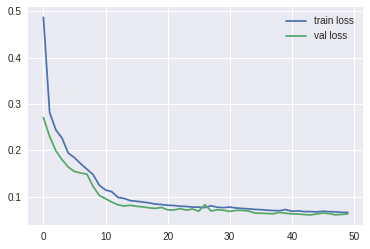

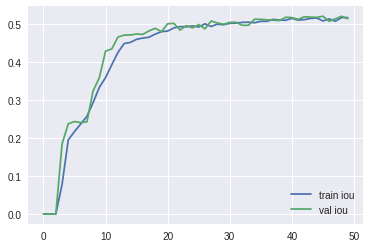

In [49]:
loss = results.history['loss']
val_loss = results.history['val_loss']
acc = results.history['my_iou_metric']
val_acc = results.history['val_my_iou_metric']
plt.figure()
plt.plot(np.arange(len(loss)), np.array(loss), label='train loss')
plt.plot(np.arange(len(val_loss)), np.array(val_loss), label='val loss')
plt.legend(loc=1)

plt.figure()
plt.plot(np.arange(len(acc)), np.array(acc), label='train iou')
plt.plot(np.arange(len(val_acc)), np.array(val_acc), label='val iou')
plt.legend(loc=4)

### Load best model and evaluate

In [50]:
best_model = load_model('best_model.h5', custom_objects={'my_iou_metric': my_iou_metric})
print('Predicting...')
train_pred = best_model.predict(train_img, verbose=1)
val_pred = best_model.predict(val_img, verbose=1)
test_pred = best_model.predict(test_img, verbose=1)
train_iou = iou_metric_batch(train_mask, train_pred)
val_iou = iou_metric_batch(val_mask, val_pred)
print('Best train IOU = ', train_iou)
print('Best val IOU = ', val_iou)

Predicting...
65/65 [==============================] - 1s 8ms/step
Best train IOU =  0.52886134
Best val IOU =  0.5205696


### Visualizations

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


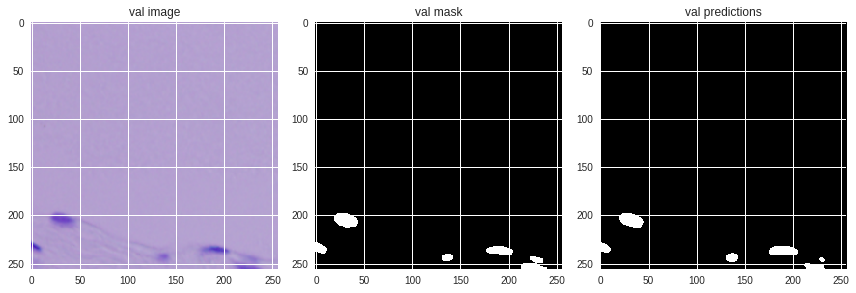

In [39]:
idx = np.random.choice(range(len(val_img)))
plt.figure(figsize=(12,12))
plt.subplot(131)
imshow(val_img[idx])
plt.title("val image")
plt.subplot(132)
imshow(np.squeeze(val_mask[idx]))
plt.title("val mask")
plt.subplot(133)
imshow(np.squeeze(val_pred[idx] > 0.5))
plt.title("val predictions")
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


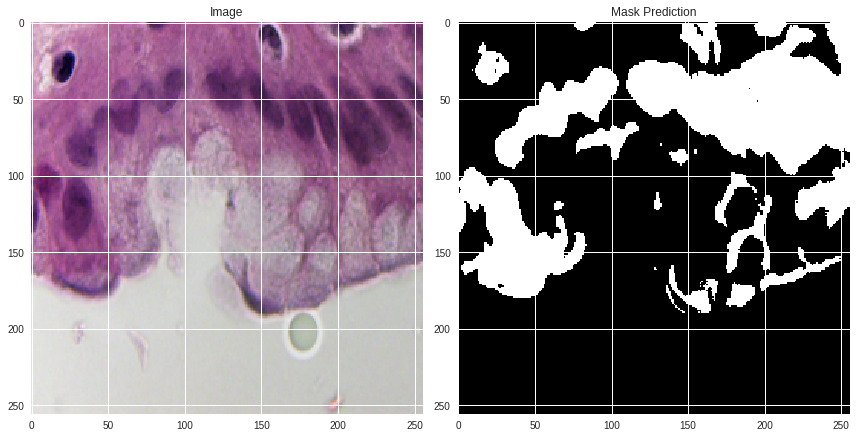

In [40]:
idx = np.random.choice(range(len(test_img)))
plt.figure(figsize=(12,12))
plt.subplot(121)
imshow(test_img[idx])
plt.title("Image")
plt.subplot(122)
imshow(np.squeeze(test_pred[idx] > 0.5))
plt.title("Mask Prediction")
plt.show()

### Submission

In [0]:
# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(test_pred)):
    test_mask_upsampled.append(resize(np.squeeze(test_pred[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('sub-dsbowl2018.csv', index=False)

In [0]:
# Code to download files from Google colab

from google.colab import files
files.download('sub-dsbowl2018.csv')
# files.download('best_model.h5')